##### Copyright 2020 Google LLC.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/google-research/big_transfer/blob/master/colabs/big_transfer_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BigTransfer (BiT): A step-by-step tutorial for state-of-the-art vision

This colab demonstrates how to:
1. Load BiT models in PyTorch
2. Make predictions using BiT pre-trained on ImageNet
3. Fine-tune BiT on 5-shot CIFAR10 and get amazing results!

It is good to get an understanding or quickly try things. However, to run longer training runs, we recommend using the commandline scripts at http://github.com/google-research/big_transfer

In [2]:
from datetime import datetime

now = datetime.now()

start_time = now.strftime("%H:%M:%S")
print("Start Time =", start_time)

Start Time = 05:19:04


In [3]:
from functools import partial
from collections import OrderedDict

In [4]:
%config InlineBackend.figure_format = 'retina'

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision as tv

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Reading weight data from the Cloud bucket

In [7]:
import requests
import io

In [8]:
def get_weights(bit_variant):
  response = requests.get(f'https://storage.googleapis.com/bit_models/{bit_variant}.npz')
  response.raise_for_status()
  return np.load(io.BytesIO(response.content))

In [9]:
weights = get_weights('BiT-M-R50x3')  # You could use other variants, such as R101x3 or R152x4 here, but it is not advisable in a colab.

# Defining the architecture and loading weights

In [10]:
class StdConv2d(nn.Conv2d):
  def forward(self, x):
    w = self.weight
    v, m = torch.var_mean(w, dim=[1, 2, 3], keepdim=True, unbiased=False)
    w = (w - m) / torch.sqrt(v + 1e-10)
    return F.conv2d(x, w, self.bias, self.stride, self.padding, self.dilation, self.groups)

In [11]:
def conv3x3(cin, cout, stride=1, groups=1, bias=False):
  return StdConv2d(cin, cout, kernel_size=3, stride=stride, padding=1, bias=bias, groups=groups)

def conv1x1(cin, cout, stride=1, bias=False):
  return StdConv2d(cin, cout, kernel_size=1, stride=stride, padding=0, bias=bias)

In [12]:
def tf2th(conv_weights):
  """Possibly convert HWIO to OIHW"""
  if conv_weights.ndim == 4:
    conv_weights = np.transpose(conv_weights, [3, 2, 0, 1])
  return torch.from_numpy(conv_weights)

In [13]:
class PreActBottleneck(nn.Module):
  """
  Follows the implementation of "Identity Mappings in Deep Residual Networks" here:
  https://github.com/KaimingHe/resnet-1k-layers/blob/master/resnet-pre-act.lua

  Except it puts the stride on 3x3 conv when available.
  """
  def __init__(self, cin, cout=None, cmid=None, stride=1):
    super().__init__()
    cout = cout or cin
    cmid = cmid or cout//4

    self.gn1 = nn.GroupNorm(32, cin)
    self.conv1 = conv1x1(cin, cmid)
    self.gn2 = nn.GroupNorm(32, cmid)
    self.conv2 = conv3x3(cmid, cmid, stride)  # Original ResNetv2 has it on conv1!!
    self.gn3 = nn.GroupNorm(32, cmid)
    self.conv3 = conv1x1(cmid, cout)
    self.relu = nn.ReLU(inplace=True)

    if (stride != 1 or cin != cout):
      # Projection also with pre-activation according to paper.
      self.downsample = conv1x1(cin, cout, stride)

  def forward(self, x):
      # Conv'ed branch
      out = self.relu(self.gn1(x))

      # Residual branch
      residual = x
      if hasattr(self, 'downsample'):
          residual = self.downsample(out)

      # The first block has already applied pre-act before splitting, see Appendix.
      out = self.conv1(out)
      out = self.conv2(self.relu(self.gn2(out)))
      out = self.conv3(self.relu(self.gn3(out)))

      return out + residual

  def load_from(self, weights, prefix=''):
    with torch.no_grad():
      self.conv1.weight.copy_(tf2th(weights[prefix + 'a/standardized_conv2d/kernel']))
      self.conv2.weight.copy_(tf2th(weights[prefix + 'b/standardized_conv2d/kernel']))
      self.conv3.weight.copy_(tf2th(weights[prefix + 'c/standardized_conv2d/kernel']))
      self.gn1.weight.copy_(tf2th(weights[prefix + 'a/group_norm/gamma']))
      self.gn2.weight.copy_(tf2th(weights[prefix + 'b/group_norm/gamma']))
      self.gn3.weight.copy_(tf2th(weights[prefix + 'c/group_norm/gamma']))
      self.gn1.bias.copy_(tf2th(weights[prefix + 'a/group_norm/beta']))
      self.gn2.bias.copy_(tf2th(weights[prefix + 'b/group_norm/beta']))
      self.gn3.bias.copy_(tf2th(weights[prefix + 'c/group_norm/beta']))
      if hasattr(self, 'downsample'):
        self.downsample.weight.copy_(tf2th(weights[prefix + 'a/proj/standardized_conv2d/kernel']))
    return self

In [14]:
class ResNetV2(nn.Module):
  BLOCK_UNITS = {
      'r50': [3, 4, 6, 3],
      'r101': [3, 4, 23, 3],
      'r152': [3, 8, 36, 3],
  }

  def __init__(self, block_units, width_factor, head_size=21843, zero_head=False):
    super().__init__()
    wf = width_factor  # shortcut 'cause we'll use it a lot.

    self.root = nn.Sequential(OrderedDict([
        ('conv', StdConv2d(3, 64*wf, kernel_size=7, stride=2, padding=3, bias=False)),
        ('padp', nn.ConstantPad2d(1, 0)),
        ('pool', nn.MaxPool2d(kernel_size=3, stride=2, padding=0)),
        # The following is subtly not the same!
        #('pool', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
    ]))

    self.body = nn.Sequential(OrderedDict([
        ('block1', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin= 64*wf, cout=256*wf, cmid=64*wf))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=256*wf, cout=256*wf, cmid=64*wf)) for i in range(2, block_units[0] + 1)],
        ))),
        ('block2', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin=256*wf, cout=512*wf, cmid=128*wf, stride=2))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=512*wf, cout=512*wf, cmid=128*wf)) for i in range(2, block_units[1] + 1)],
        ))),
        ('block3', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin= 512*wf, cout=1024*wf, cmid=256*wf, stride=2))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=1024*wf, cout=1024*wf, cmid=256*wf)) for i in range(2, block_units[2] + 1)],
        ))),
        ('block4', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin=1024*wf, cout=2048*wf, cmid=512*wf, stride=2))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=2048*wf, cout=2048*wf, cmid=512*wf)) for i in range(2, block_units[3] + 1)],
        ))),
    ]))

    self.zero_head = zero_head
    self.head = nn.Sequential(OrderedDict([
        ('gn', nn.GroupNorm(32, 2048*wf)),
        ('relu', nn.ReLU(inplace=True)),
        ('avg', nn.AdaptiveAvgPool2d(output_size=1)),
        ('conv', nn.Conv2d(2048*wf, head_size, kernel_size=1, bias=True)),
    ]))
  
  def forward(self, x):
    x = self.head(self.body(self.root(x)))
    assert x.shape[-2:] == (1, 1)  # We should have no spatial shape left.
    return x[...,0,0]

  def load_from(self, weights, prefix='resnet/'):
    with torch.no_grad():
      self.root.conv.weight.copy_(tf2th(weights[f'{prefix}root_block/standardized_conv2d/kernel']))
      self.head.gn.weight.copy_(tf2th(weights[f'{prefix}group_norm/gamma']))
      self.head.gn.bias.copy_(tf2th(weights[f'{prefix}group_norm/beta']))
      if self.zero_head:
        nn.init.zeros_(self.head.conv.weight)
        nn.init.zeros_(self.head.conv.bias)
      else:
        self.head.conv.weight.copy_(tf2th(weights[f'{prefix}head/conv2d/kernel']))
        self.head.conv.bias.copy_(tf2th(weights[f'{prefix}head/conv2d/bias']))

      for bname, block in self.body.named_children():
        for uname, unit in block.named_children():
          unit.load_from(weights, prefix=f'{prefix}{bname}/{uname}/')
    return self

# Boilerplate

In [15]:
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [16]:
def stairs(s, v, *svs):
    """ Implements a typical "stairs" schedule for learning-rates.
    Best explained by example:
    stairs(s, 0.1, 10, 0.01, 20, 0.001)
    will return 0.1 if s<10, 0.01 if 10<=s<20, and 0.001 if 20<=s
    """
    for s0, v0 in zip(svs[::2], svs[1::2]):
        if s < s0:
            break
        v = v0
    return v

def rampup(s, peak_s, peak_lr):
  if s < peak_s:  # Warmup
    return s/peak_s * peak_lr
  else:
    return peak_lr

def schedule(s):
  step_lr = stairs(s, 3e-3, 200, 3e-4, 300, 3e-5, 400, 3e-6, 500, None)
  return rampup(s, 100, step_lr)

# CIFAR-10 Example

In [17]:
import PIL

In [18]:
preprocess_train = tv.transforms.Compose([
    tv.transforms.Resize((160, 160), interpolation=PIL.Image.BILINEAR),  # It's the default, just being explicit for the reader.
    tv.transforms.RandomCrop((128, 128)),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Get data into [-1, 1]
])

preprocess_eval = tv.transforms.Compose([
    tv.transforms.Resize((128, 128), interpolation=PIL.Image.BILINEAR),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = tv.datasets.CIFAR10(root='./data', train=True, download=True, transform=preprocess_train)
testset = tv.datasets.CIFAR10(root='./data', train=False, download=True, transform=preprocess_eval)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Eval pre-trained model (verify conversion)

In [19]:
# 'BiT-M-R50x1-CIFAR10' change to 'BiT-M-R50x3'
#weights_cifar10 = get_weights('BiT-M-R50x3')

In [20]:
#model = ResNetV2(ResNetV2.BLOCK_UNITS['r50'], width_factor=3, head_size=10)  # NOTE: No new head.
#model.load_from(weights_cifar10)
#model.to(device);

In [21]:
def eval_cifar10(model, bs=100, progressbar=True):
  loader_test = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False, num_workers=2)

  model.eval()

  if progressbar is True:
    progressbar = display(progress(0, len(loader_test)), display_id=True)

  preds = []
  with torch.no_grad():
    for i, (x, t) in enumerate(loader_test):
      x, t = x.to(device), t.numpy()
      logits = model(x)
      _, y = torch.max(logits.data, 1)
      preds.extend(y.cpu().numpy() == t)
      progressbar.update(progress(i+1, len(loader_test)))

  return np.mean(preds)

In [22]:
#print("Expected: 97.61%")
#print(f"Accuracy: {eval_cifar10(model):.2%}")

## Find indices to create a 5-shot CIFAR10 variant

In [23]:
preprocess_tiny = tv.transforms.Compose([tv.transforms.CenterCrop((2, 2)), tv.transforms.ToTensor()])
trainset_tiny = tv.datasets.CIFAR10(root='./data', train=True, download=True, transform=preprocess_tiny)
loader = torch.utils.data.DataLoader(trainset_tiny, batch_size=50000, shuffle=False, num_workers=2)
images, labels = iter(loader).next()


Files already downloaded and verified


In [24]:
indices = {cls: np.random.choice(np.where(labels.numpy() == cls)[0], 5, replace=False) for cls in range(10)}

In [25]:
print(indices)

{0: array([ 3382, 19009, 11487, 48979, 33750]), 1: array([17752, 34445, 28763,  9365, 26637]), 2: array([42986, 35880, 16221, 45015, 27169]), 3: array([ 8609, 39013, 28447, 42252, 19920]), 4: array([43950, 27535, 31804,  1297, 22642]), 5: array([ 7935, 28531, 27918, 30540,  8320]), 6: array([ 1563, 30001,  1531, 46550, 19308]), 7: array([15070, 39798,   237, 30421,  2000]), 8: array([28269, 34712, 19991,  5360, 39239]), 9: array([25159, 12957, 20683, 27245, 14705])}


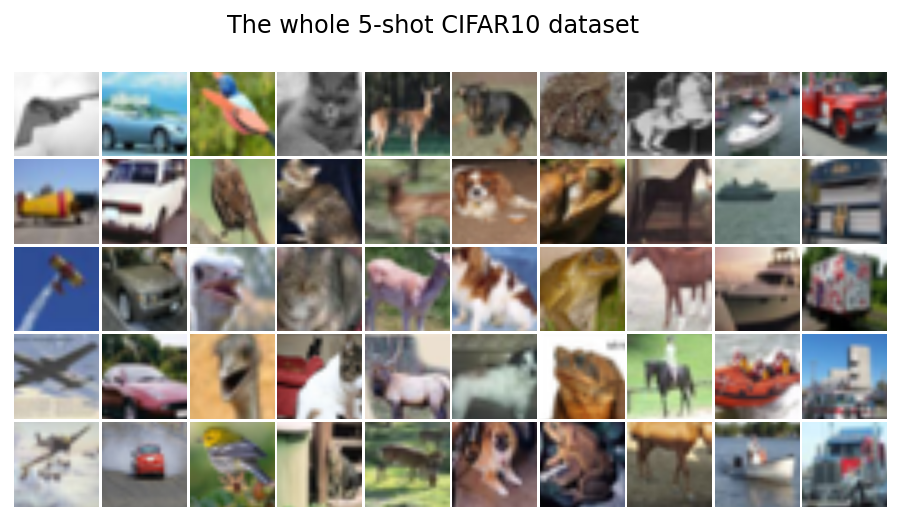

In [26]:
fig = plt.figure(figsize=(10, 4))
ig = ImageGrid(fig, 111, (5, 10))
for c, cls in enumerate(indices):
  for r, i in enumerate(indices[cls]):
    img, _ = trainset[i]
    ax = ig.axes_column[c][r]
    ax.imshow((img.numpy().transpose([1, 2, 0]) * 127.5 + 127.5).astype(np.uint8))
    ax.set_axis_off()
fig.suptitle('The whole 5-shot CIFAR10 dataset');

In [27]:
train_5shot = torch.utils.data.Subset(trainset, indices=[i for v in indices.values() for i in v])
len(train_5shot)

50

# Fine-tune BiT-M on this 5-shot CIFAR10 variant

**NOTE**: In this very low data regime, the performance heavily depends on how "representative" the 5 examples you got are of the class. As shown in the paper, variance is very large, I'm getting anywhere between 78%-85% depending on luck.

Another point is that here I use `batch_size=512` for consistency with the paper. But actually, a much smaller `batch_size=50` works just as well and is about 10x faster!

In [28]:
# ResNet50-x3
model = ResNetV2(ResNetV2.BLOCK_UNITS['r50'], width_factor=3, head_size=10, zero_head=True)
model.load_from(weights)
model.to(device);

In [29]:
# Yes, we still use 512 batch-size! Maybe something else is even better, who knows.
# loader_train = torch.utils.data.DataLoader(train_5shot, batch_size=512, shuffle=True, num_workers=2)

# NOTE: This is necessary when the batch-size is larger than the dataset.
sampler = torch.utils.data.RandomSampler(train_5shot, replacement=True, num_samples=256)
loader_train = torch.utils.data.DataLoader(train_5shot, batch_size=32, num_workers=2, sampler=sampler)

In [30]:
crit = nn.CrossEntropyLoss()
opti = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
model.train();

In [31]:
S = 500
def schedule(s):
  step_lr = stairs(s, 3e-3, 200, 3e-4, 300, 3e-5, 400, 3e-6, S, None)
  return rampup(s, 100, step_lr)

pb_train = display(progress(0, S), display_id=True)
pb_test = display(progress(0, 100), display_id=True)
losses = [[]]
accus_train = [[]]
accus_test = []

steps_per_iter = 512 // loader_train.batch_size

while len(losses) < S:
  for x, t in loader_train:
    x, t = x.to(device), t.to(device)

    logits = model(x)
    loss = crit(logits, t) / steps_per_iter
    loss.backward()
    losses[-1].append(loss.item())

    with torch.no_grad():
      accus_train[-1].extend(torch.max(logits, dim=1)[1].cpu().numpy() == t.cpu().numpy())

    if len(losses[-1]) == steps_per_iter:
      losses[-1] = sum(losses[-1])
      losses.append([])
      accus_train[-1] = np.mean(accus_train[-1])
      accus_train.append([])

      # Update learning-rate according to schedule, and stop if necessary
      lr = schedule(len(losses) - 1)
      for param_group in opti.param_groups:
        param_group['lr'] = lr

      opti.step()
      opti.zero_grad()

      pb_train.update(progress(len(losses) - 1, S))
      print(f'\r[Step {len(losses) - 1}] loss={losses[-2]:.2e} '
            f'train accu={accus_train[-2]:.2%} '
            f'test accu={accus_test[-1] if accus_test else 0:.2%} '
            f'(lr={lr:g})', end='', flush=True)

      if len(losses) % 25 == 0:
        accus_test.append(eval_cifar10(model, progressbar=pb_test))
        model.train()

[Step 499] loss=2.80e-06 train accu=100.00% test accu=87.93% (lr=3e-06)

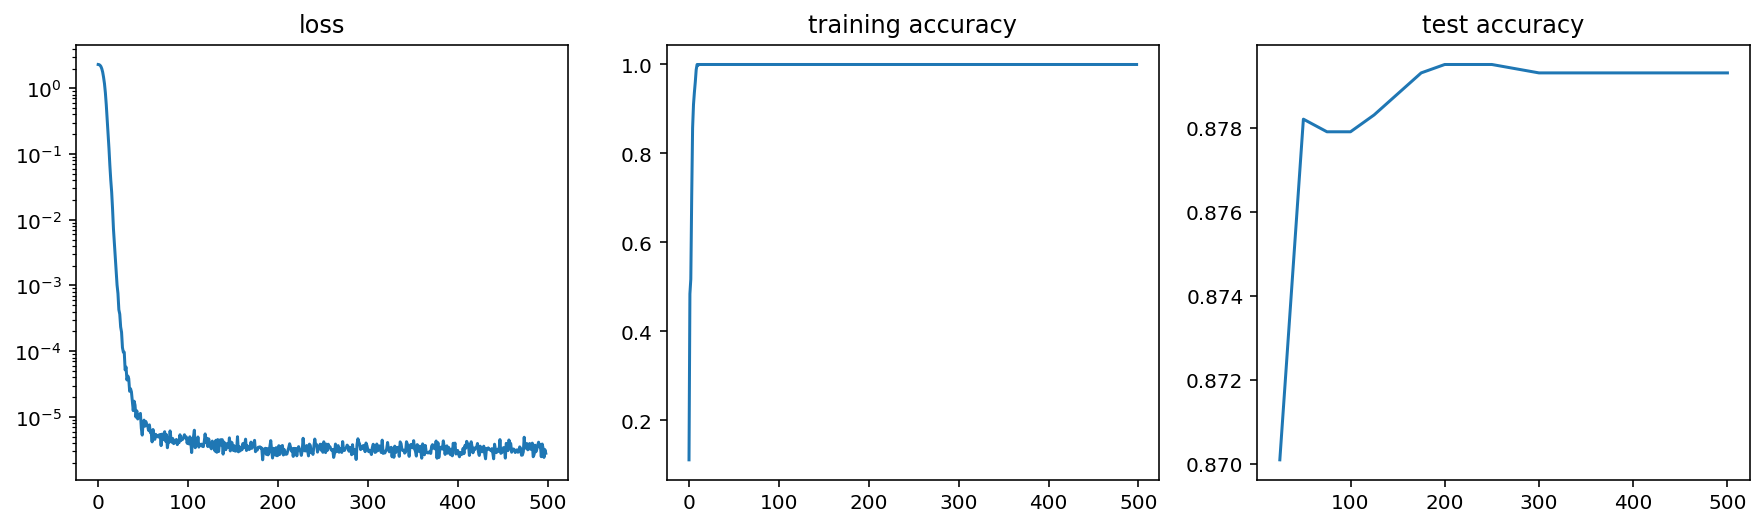

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
ax1.plot(losses[:-1])
ax1.set_yscale('log')
ax1.set_title('loss')
ax2.plot(accus_train[:-1])
ax2.set_title('training accuracy')
ax3.plot(np.arange(25, 501, 25), accus_test)
ax3.set_title('test accuracy');

In [33]:
now = datetime.now()

stop_time = now.strftime("%H:%M:%S")
print("Stop Time =", stop_time)

Stop Time = 06:38:12


In [34]:
print(datetime.strptime(stop_time, "%H:%M:%S") - datetime.strptime(start_time, "%H:%M:%S"))

1:19:08
